In [1]:
import pandas as pd
import cv2
import numpy as np
import random
from MainFunctions import loadTrainingData,  loadRealLoaders, buildDataFromParams, loadTrainLoaders	
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math
import torch
from tqdm import tqdm
import torchmetrics

c:\Users\Michi\uksh\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
random.seed(SEED)
logfolder = "results"

In [4]:
# code idea from https://stackoverflow.com/questions/46274961/removing-horizontal-lines-in-image-opencv-python-matplotlib
# plus adaptation using  https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
def clearstraightlines(img):
    """Function for removing dotted vertical lines using morphological transformations and otsus method

    Args:
        img (np array): array containing image depicting signal

    Returns:
        img (np array): img with removed dotted line
    """
    img = img.copy()
    width = img.shape[1]
    height = img.shape[0]
    thresh = cv2.threshold(img, 0, 255,  cv2.THRESH_OTSU)[1]
    kernel = np.ones((10,3),np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, math.floor(img.shape[0] * 0.8)))
    vertical_lines = cv2.morphologyEx(closing , cv2.MORPH_OPEN, vertical_kernel , iterations=2)

    img[np.nonzero(vertical_lines)] = 0
    # remove empty columns generated by removing straight lines
    img = np.delete(img, np.argwhere(img.mean(axis=0) == 0), 1)
    # resizing to orginal size
    img = cv2.resize(np.array(img),(width,height), cv2.INTER_NEAREST)   

    return img


In [5]:
def trans_normalize(img):
    """
    Function for applying pixel normalization column wise to an image
    Args:
        img (np array): image to normalize pixels

    Returns:
        np array: normalized image
    """
    img = np.divide(img , img.sum(axis=0), out=np.zeros_like(img, dtype='float64'), where=img.sum(axis=0) > 0)
    return img

In [6]:
def prepareimg(img, size, clearlines = True):
  """General function for cleaning and transforming an image such that predictions using the algorithm can be executed

  Args:
      img (np array): img to process
      size (int,int): tuple containing resizing shape
      clearlines (bool, optional): controls whether to apply the clearing algorithm. Defaults to True.

  Returns:
      np array: processed image
  """
  width = size[1]
  height = size[0]
  img = clearstraightlines(img) if clearlines else img
  img = cv2.resize(np.array(img),(width,height), cv2.INTER_NEAREST)
  img = trans_normalize(img)

  return img

In [7]:
def buildseries(img, method):
    """Function for extracting timeseries from img

    Returns:
        list: extracted time series
    """
    series = []
    for a in img.T:
        try:
            if method == "average":
                series.append(np.average(np.argwhere(a > 0).flatten(), weights=a[a>0]))
            elif method == "maxintensity":
                series.append(np.average(np.argwhere(a == a.max())))
        except ZeroDivisionError:
            print("NOT Identifiable")
            series.append(0)
    return series

In [8]:
def algorithm_pred(pairs, images, labels, method, dummy):
    """Function for executing algorithm predictions

    Args:
        pairs (np array): array with image pair indexes
        images (np array): array with images
        labels (np array): array with correlation labels
        method (string): method to apply for pixel transformation
        dummy (bool): param controlling use of baseline vs algorithm

    Returns:
        np array, np array, float, pd dataframe: calculated evaluation metrics (mae, mse, r2) and dataframe containing all results
    """
    preds = []

    for pair in pairs:
        img1 = np.array(images[pair[0]])
        img2 = np.array(images[pair[1]])
        size = (min(img1.shape[0], img2.shape[0]),  min(img1.shape[1], img2.shape[1]))           
        pred = pearsonr(buildseries(prepareimg(img1, size),method), buildseries(prepareimg(img2, size),method))[0] if not dummy else random.randint(-100,100) / 100
        preds.append(pred)

    df = pd.DataFrame({"target" : labels, "pred" : preds})
    print(f"{len(df) - df['pred'].count() } items not identifiable")
    df = df.fillna(0)
    mae = torch.nn.L1Loss()(torch.tensor(df["target"].to_numpy()), torch.tensor(df["pred"].to_numpy()))
    mse = torch.nn.MSELoss()(torch.tensor(df["target"].to_numpy()), torch.tensor(df["pred"].to_numpy()))
    r2 = torchmetrics.R2Score()(torch.tensor(df["target"].to_numpy()), torch.tensor(df["pred"].to_numpy())).item()

    return mae, mse, r2, df


In [9]:
def eval_algorithm(pairs, images, labels, dummy=False, methods = ["average", "maxintensity"]):
    """Function for evaluating the algorithm

    Args:
        pairs (np array): array with image pair indexes
        images (np array): array with images
        labels (np array): array with correlation labels
        dummy (bool): param controlling use of baseline vs algorithm
        methods (list, optional): methods to apply for pixel transformation. Defaults to ["average", "maxintensity"]

    Returns:
        dict: dictionary containing results for each method applied
    """
    res = []
    for method in methods:
        print(f"Using method {method}")
        mae, mse, r2, df = algorithm_pred(pairs,images,labels,method,dummy)
        res.append({ "trans method" : method , "mae" : mae.item(),  "mse" : mse.item(), "r2" : r2, "df" : df})
    return res

## Loading Uniform and Randomized AI Data

In [10]:
uniform_loaders = loadTrainLoaders( batch_size=32, datatype="pearson", transform="transform_padding", invert=False, percentages=np.array([0.70,0.15,0.15]), reduceindex=None, augment=True, seed=SEED )
val_uniform_loader = uniform_loaders["val"]

In [11]:
train_loader, val_loader, test_loader, real_train_loader,  real_test_loader = buildDataFromParams(datatype="random_pearson", transform="transform_padding", batch_size=64)

# Preliminary Experiment investigating best transformation method

## Executing algorithm on AI validation datasets

In [12]:
images, pairs, labels = val_uniform_loader.dataset.images, val_uniform_loader.dataset.pairs, val_uniform_loader.dataset.labels
res_ai_uniform =  eval_algorithm(pairs,images,labels)

images, pairs, labels = val_loader.dataset.images, val_loader.dataset.pairs, val_loader.dataset.labels
res_ai_random =  eval_algorithm(pairs,images,labels)

Using method average
0 items not identifiable
Using method maxintensity
0 items not identifiable
Using method average
0 items not identifiable
Using method maxintensity
0 items not identifiable


## Executing algorithm on ECG validation dataset

In [13]:
pairs,images,labels = real_train_loader.dataset.pairs, real_train_loader.dataset.images, real_train_loader.dataset.labels
res_real =  eval_algorithm(pairs,images,labels)

Using method average
0 items not identifiable
Using method maxintensity
0 items not identifiable


In [14]:
df_real = pd.DataFrame(res_real)[["trans method", "mae", "mse", "r2"]]
df_real["data"] = "real"

df_uniform = pd.DataFrame(res_ai_uniform)[["trans method", "mae", "mse", "r2"]]
df_uniform["data"] = "ai_uniform"

df_random = pd.DataFrame(res_ai_random)[["trans method", "mae", "mse", "r2"]]
df_random["data"] = "ai_random"

In [15]:
df = df_uniform.append([df_random, df_real]).reset_index(drop=True)


## Combining all results

In [16]:
df = df.groupby(["data", "trans method"]).min().sort_values(by="mae")
df.to_csv("results/preliminaryalgorithm.csv")
df

mae       mse        r2
data       trans method                              
ai_uniform maxintensity  0.003657  0.000027  0.999920
           average       0.004870  0.000063  0.999813
ai_random  maxintensity  0.007677  0.000354  0.998951
           average       0.014617  0.000844  0.997536
real       average       0.140969  0.069960  0.789349
           maxintensity  0.141086  0.070223  0.789848

# Eval like in main experiment using AI and ECG Test Hold Out

In [17]:
def evalLikeSetup (dtype, method="average", dummy=False):
    """Function for evaluating like in main experiment for final result comparison

    Args:
        dtype (string): type of data to use ECG or AI
        method (str, optional): transformation applied. Defaults to "average".
        dummy (bool, optional): parameter controlling if base line should be used. Defaults to False.

    Returns:
        pd dataframe: dataframe containing prediction results
    """
    pairs,images,labels = None, None, None
    if dtype == "real":
        pairs,images,labels = real_test_loader.dataset.pairs, real_test_loader.dataset.images, real_test_loader.dataset.labels
    elif dtype== "ai":
        pairs,images,labels = test_loader.dataset.pairs, test_loader.dataset.images, test_loader.dataset.labels
    res =  eval_algorithm(pairs,images,labels, methods=[method], dummy=dummy)
    df = pd.DataFrame(res)[["mae", "mse", "r2", "df"]]
    df["data"] = dtype

    return df

In [18]:
results = pd.DataFrame()
for dummy in [True, False]:
    for dtype in ["real", "ai"]:
        res = evalLikeSetup(dtype=dtype, method="average", dummy=dummy)
        res["model"] = "BaseLine" if dummy else "Algorithm"
        results = results.append(res, ignore_index=True)

Using method average
0 items not identifiable
Using method average
0 items not identifiable
Using method average
0 items not identifiable
Using method average
0 items not identifiable


In [19]:
results.groupby(["model","data"])["mae","mse","r2"].max()

mae       mse        r2
model     data                              
Algorithm ai    0.015967  0.001004  0.997075
          real  0.102447  0.052436  0.850331
BaseLine  ai    0.654243  0.654667 -0.980618
          real  0.787500  0.924531 -1.590097

# Saving Algorithm Predictions for use in explaination section


In [ ]:
results = results[results["model"] == "Algorithm"]
df_real = results[results["data"] == "real"]["df"].item()
df_real["data"] = "real"
df_ai = results[results["data"] == "ai"]["df"].item()
df_ai["data"] = "ai"
df = df_real.append(df_ai)
df.to_csv("results/algorithmfinalpreds.csv", index=False)

# Visualizing extracted signals as plots below the source image

In [24]:
def visExtractedSignal(img1, img2, vistype, title):
    """Function for visualizing extracted signals vs original images

    Args:
        img1 (np array): template img
        img2 (np array): match img
        vistype (string): vistype to use
        title (string): title for figure
    """
    fig, ax = plt.subplots(2,2,figsize=(10,7))

    if vistype == "err":
        ax[0,0].imshow(img1, origin='lower')
        ax[0,1].imshow(img2, origin='lower')
        ax[1,0].imshow(cv2.threshold(img1, 0, 255,  cv2.THRESH_OTSU)[1],origin='lower')
        ax[1,1].imshow(cv2.threshold(img2, 0, 255,  cv2.THRESH_OTSU)[1],origin='lower')
        
    elif vistype == "corr":
        size = (min(img1.shape[0], img2.shape[0]),  min(img1.shape[1], img2.shape[1]))            
        ax[0,0].imshow(img1, origin='lower')
        ax[0,1].imshow(img2, origin='lower')
        ax[1,0].plot(buildseries(prepareimg(img1, size), method="average"))
        ax[1,0].set_ylim([0, img1.shape[0]])
        ax[1,1].plot(buildseries(prepareimg(img2, size), method="average"))
        ax[1,1].set_ylim([0, img2.shape[0]])

    for a in ax.flatten():
        a.set_xlabel( "Time in ms")
        a.set_ylabel( "Signal amplitude")
    fig.suptitle(title)


In [26]:
pairs,images,labels = real_test_loader.dataset.pairs, real_test_loader.dataset.images, real_test_loader.dataset.labels

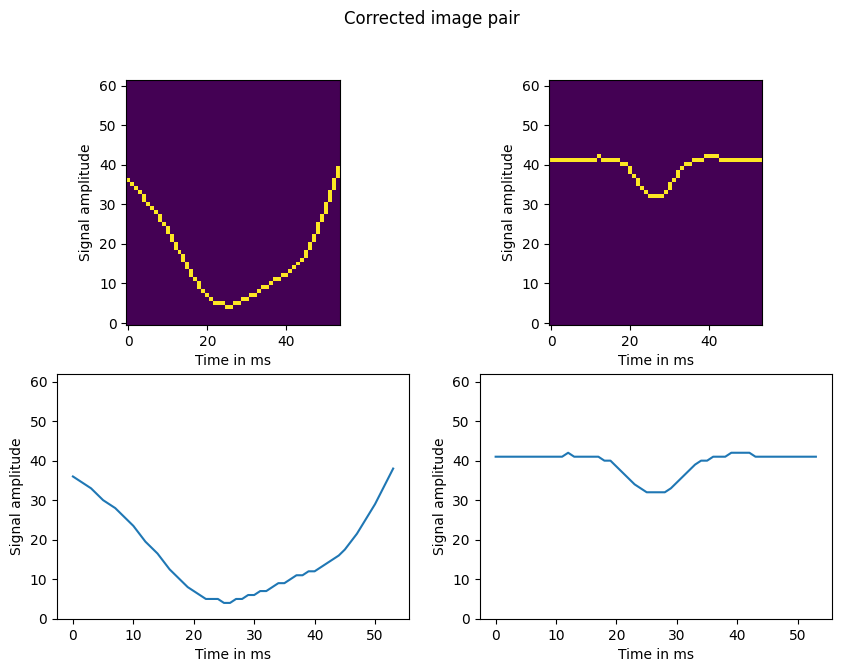

In [28]:
visExtractedSignal(img1= np.array(images[pairs[90][0]]), img2=np.array(images[pairs[90][1]]), vistype="corr", title="Corrected image pair")

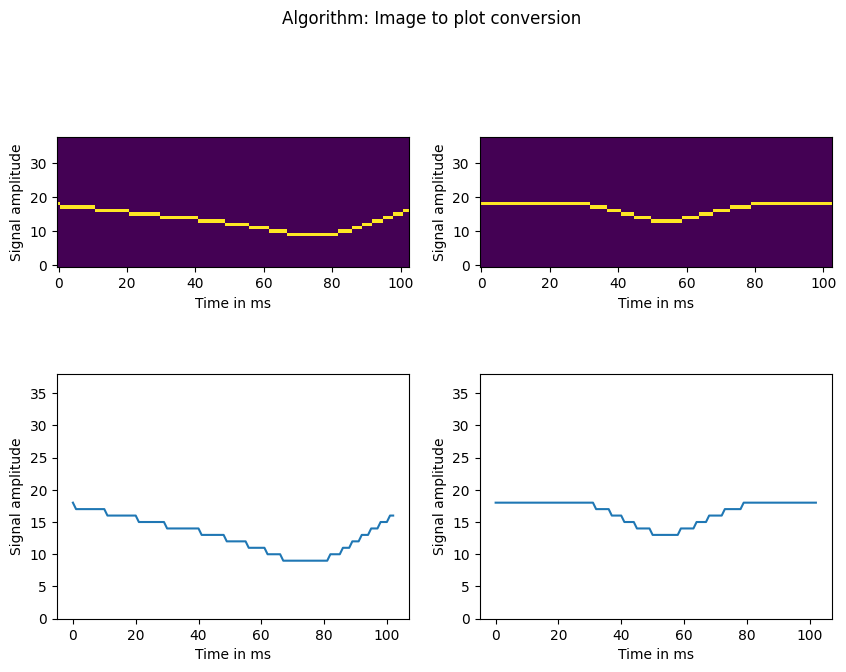

In [29]:
visExtractedSignal(img1= np.array(images[pairs[75][0]]), img2=np.array(images[pairs[75][1]]), vistype="corr", title="Algorithm: Image to plot conversion")